In [63]:
#### loading packages
import numpy as np # linear algebra
import pandas as pd # for easier csv parsing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image # Pillow Image Processing
from scipy.misc import imread
from sklearn.model_selection import RepeatedKFold

import tensorflow as tf
sns.set()

import os
path="/media/haidro/harddisk1t/kaggle/protein_atlas"
print(os.listdir(path))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

['test', '.ipynb_checkpoints', 'sample_submission.csv', 'train', 'train.csv']


In [64]:
train_labels = pd.read_csv(path+"/train.csv")
print("There is %s samples in traininig set."%train_labels.shape[0])
test_labels = pd.read_csv(path+"/sample_submission.csv")
print("There is %s samples in testing set."%test_labels.shape[0])

There is 31072 samples in traininig set.
There is 11702 samples in testing set.


In [65]:
# train_labels
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


There are in total 28 different labels present in the dataset. 

In [66]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [14]:
label_names

{0: 'Nucleoplasm',
 1: 'Nuclear membrane',
 2: 'Nucleoli',
 3: 'Nucleoli fibrillar center',
 4: 'Nuclear speckles',
 5: 'Nuclear bodies',
 6: 'Endoplasmic reticulum',
 7: 'Golgi apparatus',
 8: 'Peroxisomes',
 9: 'Endosomes',
 10: 'Lysosomes',
 11: 'Intermediate filaments',
 12: 'Actin filaments',
 13: 'Focal adhesion sites',
 14: 'Microtubules',
 15: 'Microtubule ends',
 16: 'Cytokinetic bridge',
 17: 'Mitotic spindle',
 18: 'Microtubule organizing center',
 19: 'Centrosome',
 20: 'Lipid droplets',
 21: 'Plasma membrane',
 22: 'Cell junctions',
 23: 'Mitochondria',
 24: 'Aggresome',
 25: 'Cytosol',
 26: 'Cytoplasmic bodies',
 27: 'Rods & rings'}

In [15]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


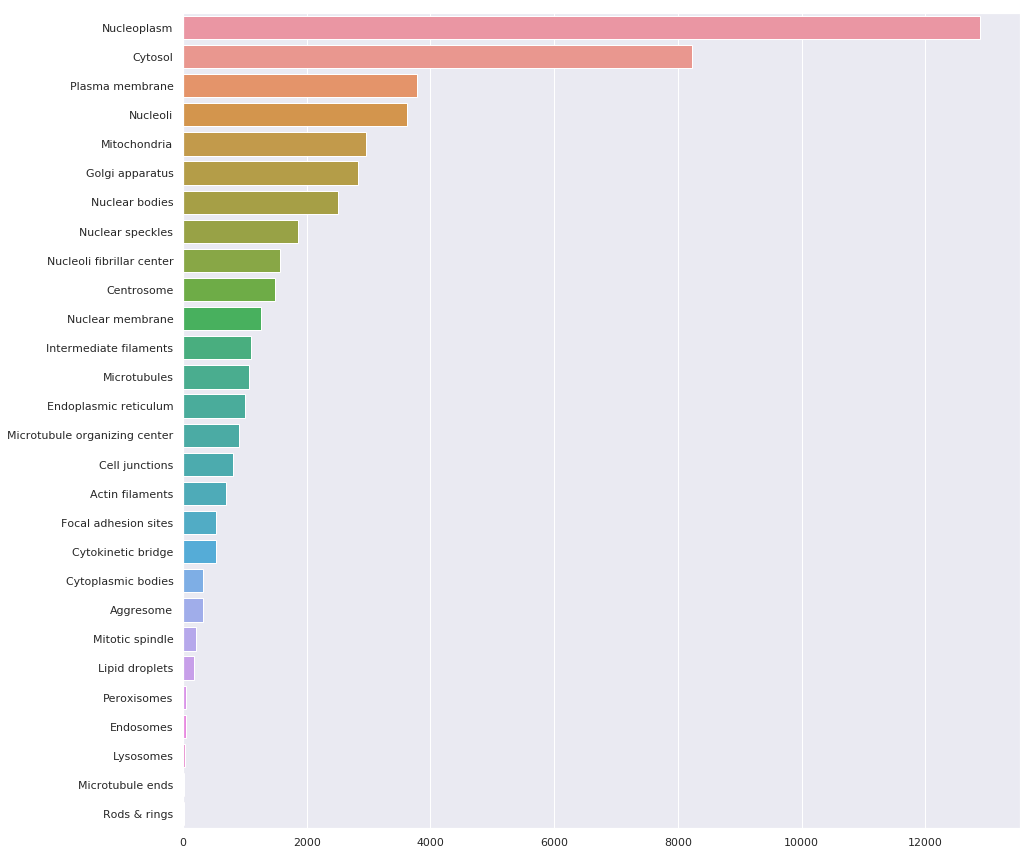

In [16]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

Each image is of size $ 512 \times 512 $. All image samples are represented by four filters.
##### Green 
Indicates the protein of interest. It shows thw stained target proteins and consequently it's the most informative one.
##### Blue
Indicates the nucleus
##### Red
Indicates the microtubules
##### Yellow
Indicates the endoplasmic reticulum

Notice, the green filter should be used to predict the label, other filters are used as references. 

In [19]:
from os import listdir

files = listdir(path+"/train")
for n in range(10):
    print(files[n])

04fd5b44-bbb3-11e8-b2ba-ac1f6b6435d0_blue.png
4177442e-bbac-11e8-b2ba-ac1f6b6435d0_green.png
9222e6c0-bbc6-11e8-b2bc-ac1f6b6435d0_green.png
75b8a772-bbad-11e8-b2ba-ac1f6b6435d0_green.png
7c51db4e-bb9e-11e8-b2b9-ac1f6b6435d0_blue.png
6b625baa-bba9-11e8-b2ba-ac1f6b6435d0_red.png
1aad8f22-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
834dd082-bbae-11e8-b2ba-ac1f6b6435d0_red.png
ece3eb24-bbba-11e8-b2ba-ac1f6b6435d0_green.png
91848b9e-bbb5-11e8-b2ba-ac1f6b6435d0_green.png


###### Build an batch loader

In [21]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [22]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(self.target_list).issuperset(set(targets)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images
            

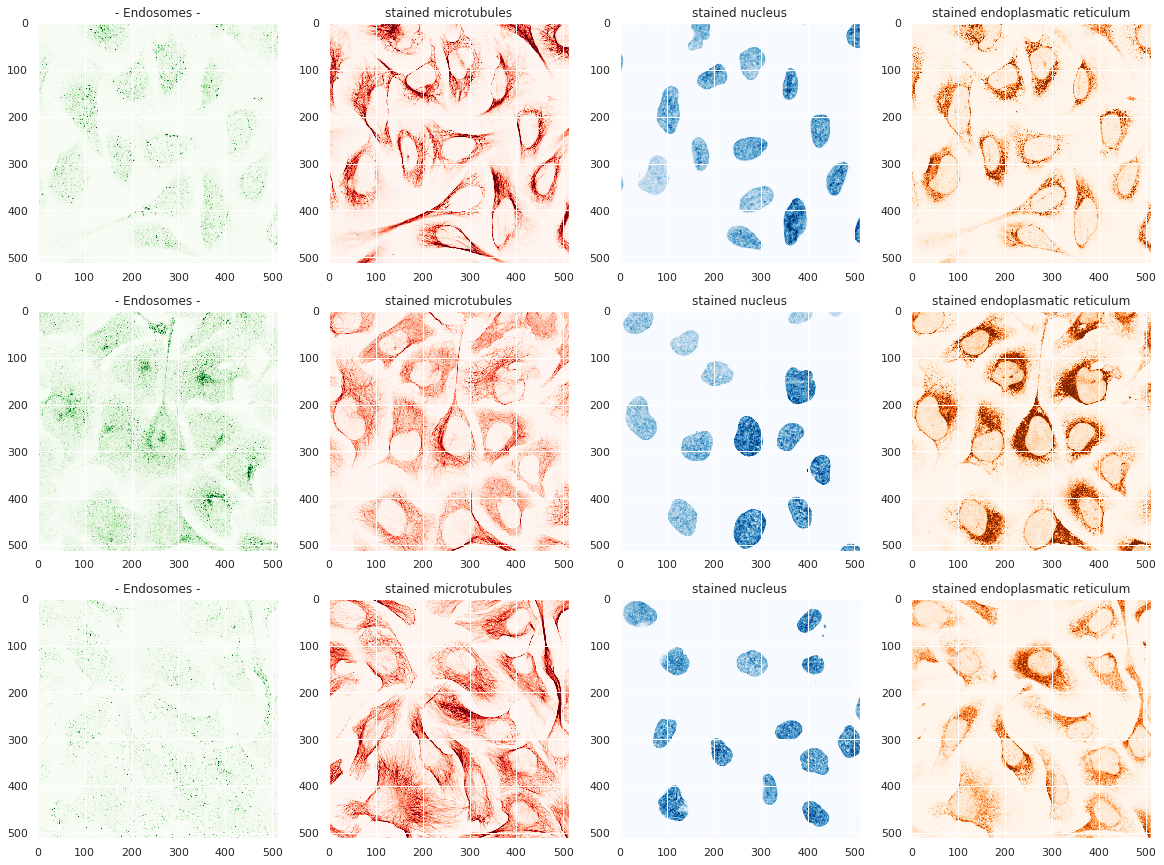

In [27]:
train_path=path+'/train/'
your_choice = [ "Endosomes"]
your_batch_size = 3
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

In [29]:
splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357


##### Image Preprocessor

In [30]:
from skimage.transform import resize

class ImagePreprocessor:
    
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.resize(image)
        image = self.reshape(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def normalize(self, image):
        image /= 255 
        return image
    
    def load_image(self, image_id):
        image = np.zeros(shape=(512,512,4))
        image[:,:,0] = imread(self.basepath + image_id + "_green" + ".png")
        image[:,:,1] = imread(self.basepath + image_id + "_blue" + ".png")
        image[:,:,2] = imread(self.basepath + image_id + "_red" + ".png")
        image[:,:,3] = imread(self.basepath + image_id + "_yellow" + ".png")
        return image[:,:,0:self.parameter.n_channels]
        

(512, 512)
(128, 128, 1)


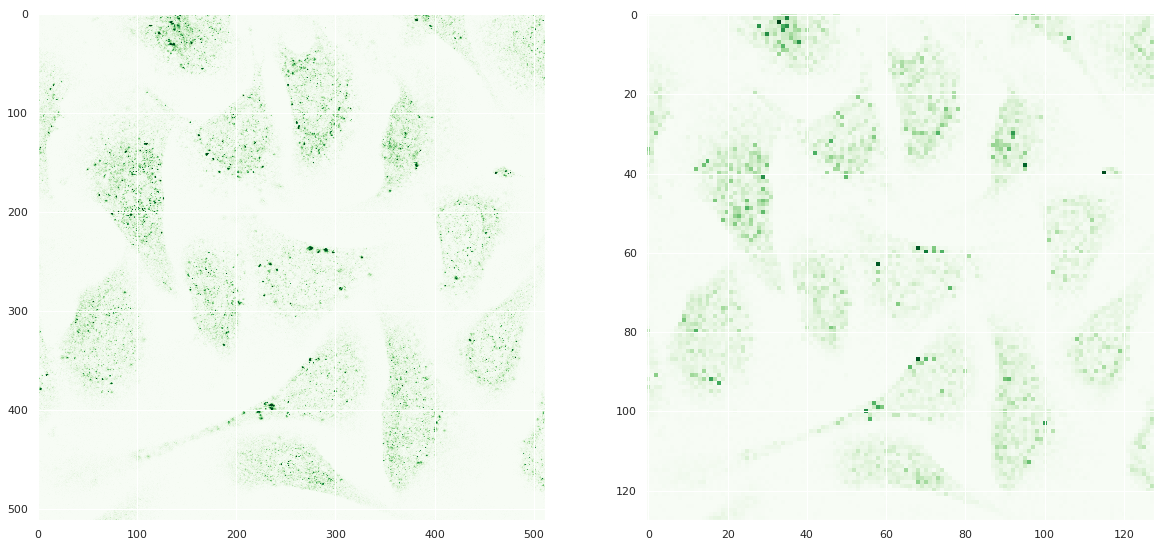

In [59]:
class ModelParameter:
    
    def __init__(self, basepath,
                 num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=200,
                 n_channels=1,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 shuffle=False,
                 n_epochs=1):
        self.basepath = basepath
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs
parameter = ModelParameter(train_path)
preprocessor = ImagePreprocessor(parameter)

example = images[0,0]
preprocessed = preprocessor.preprocess(example)
print(example.shape)
print(preprocessed.shape)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(example, cmap="Greens")
ax[1].imshow(preprocessed.reshape(parameter.scaled_row_dim,parameter.scaled_col_dim), cmap="Greens")

(3, 4, 512, 512)